# IMA 201 - Rapport de fin de projet  : Segmentation de lésions cutanées
*Pierre MARCHETTI / Alexandre HEYMANN*

*Encadrant : Pietro GORI*

In [12]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import data
from skimage import io as skio
from skimage.filters import threshold_otsu

image_test = Image.open("ISIC_0000042.jpg")

## Description du projet 
Le mélanome est la forme la plus mortelle de cancer de la peau, cependant sa détection aux premiers stades est difficile car ils ressemblent à des grains de beauté communs. Des algorithmes et des systèmes de diagnostic assisté par ordinateur ont été développés pour soutenir les cliniciens dans cette tâche. L'une des premières étapes, et l'objectif de notre projet, est la segmentation de ces lésions cutanées. 
Pour ce faire, notre travail est divisé en trois étapes : **pré-processing** (redimensionnement de l'image, suppresion du cadre noir, lissage de l'image), **élimination des poils** et enfin **segmentation**.

## Description des travaux effectués

### Pré-processing

**Redimensionnement**

Les images de notre base de données ne sont pas toutes de la même dimensions. Afin de normaliser ce paramètre nous mettons toutes nos images à la même taille, en 256x256.

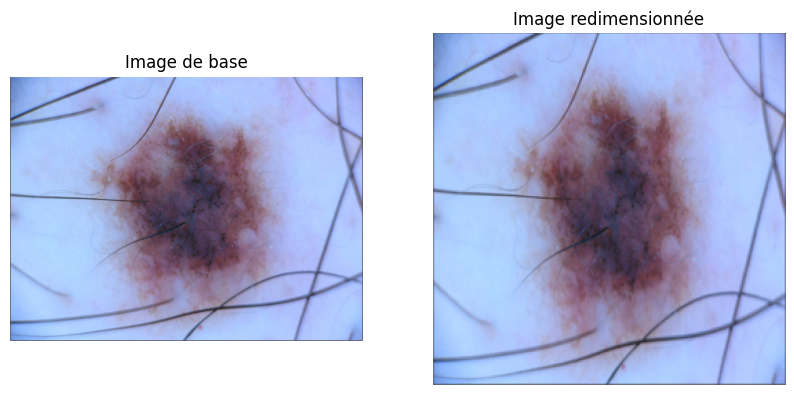

Taille image de base : 1504x1129
Taille image redimensionnée : 256x256


In [13]:
def redimensionner_image(image, nouvelle_largeur, nouvelle_hauteur):
    nouvelle_image = image.resize((nouvelle_largeur, nouvelle_hauteur))
    nouvelle_image.save("ISIC_0000042_resize.jpg")
    return nouvelle_image

nouvelle_image = redimensionner_image(image_test, 256, 256)

#Convertir l'image Pillow en NumPy array
image_np = np.array(image_test)
nouvelle_image_np = np.array(nouvelle_image)

# Afficher les images côte à côte
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Afficher l'image de base
axes[0].imshow(image_np)
axes[0].set_title('Image de base')
axes[0].axis('off')

# Afficher l'image redimensionnée
axes[1].imshow(nouvelle_image_np)
axes[1].set_title('Image redimensionnée')
axes[1].axis('off')

plt.show()
print("Taille image de base : " + str(image_np.shape[1]) + "x" + str(image_np.shape[0]))
print("Taille image redimensionnée : " + str(nouvelle_image_np.shape[1]) + "x" + str(nouvelle_image_np.shape[0]))

**Suppression du cadre noir**

Certaines images présentent des bords noirs sur les contours et cela peut fausser la détéction de contours du grain de beauté lors de la segmentation. Afin de résoudre ce problème nous supprimons ces bords noirs en considérant le plus grand rectangle de l'image intérieure. 

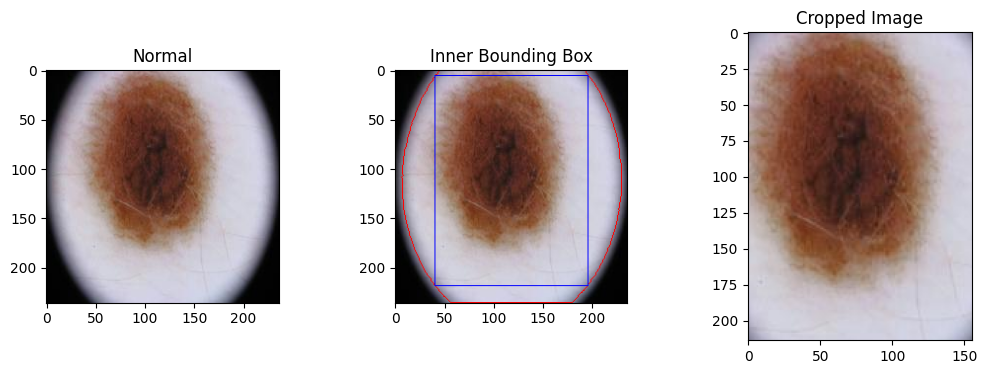

True

In [14]:
import cv2 as cv
import numpy as np
import largestinteriorrectangle as lir
import matplotlib.pyplot as plt

img = cv.imread("ISIC_0000045.jpg")
size = img.shape
img = img[10:size[0] - 10, 10:size[1] - 10]
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
_, mask = cv.threshold(gray, 0, 255, cv.THRESH_OTSU)

contours, _ = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

contour = np.array([contours[0][:, 0, :]])

inner_bb = lir.lir(contour)

cropped_img = img[inner_bb[1]:inner_bb[1] + inner_bb[3], inner_bb[0]:inner_bb[0] + inner_bb[2]]

# Créer une figure avec trois sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Afficher l'image normale
axes[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
axes[0].set_title('Normal')

# Afficher l'image avec le contour et le rectangle intérieur
plot = img.copy()
cv.polylines(plot, [contour], True, (0, 0, 255))
cv.rectangle(plot, lir.pt1(inner_bb), lir.pt2(inner_bb), (255, 0, 0))
axes[1].imshow(cv.cvtColor(plot, cv.COLOR_BGR2RGB))
axes[1].set_title('Inner Bounding Box')

# Afficher l'image détourée
axes[2].imshow(cv.cvtColor(cropped_img, cv.COLOR_BGR2RGB))
axes[2].set_title('Cropped Image')

# Ajuster l'espace entre les sous-graphiques
plt.subplots_adjust(wspace=0.5)

# Afficher la figure
plt.show()

# Enregistrer l'image détourée
cv.imwrite("foreground.jpg", cropped_img)


**Lissage de l'image**

Les images de dermatoscopie contiennent souvent des artefacts superflus tels que des lignes cutanées ou des bulles d'air autour de la lésion. Ces éléments réduisent la précision de la détection des contours et augmentent le temps de calcul. Pour atténuer les effets néfastes de ces artefacts, les images doivent être prétraitées avec un filtre de lissage.
Le filtre médian est l'un des filtres de lissage les plus courants. Un filtrage médian avec une taille de masque appropriée peut éliminer la plupart des artefacts dans une image de dermatoscopie. D'après de nombreux articles de recherches, la taille du masque doit être proportionnelle à la taille de l'image pour des résultats optimaux et la relation mathématique est la suivante : étant donné une image de taille M par N, la taille du masque n est déterminée par :

$$ n = \left\lfloor 5\sqrt{\frac{M}{768}\frac{N}{512}} \right\rfloor $$


Avec M=N=256 on obtient n=2


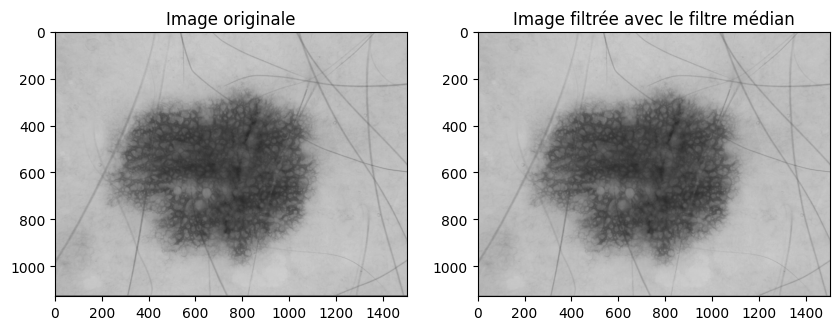

In [15]:
image_path = 'ISIC_0000019.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Charger l'image en niveaux de gris

# Appliquer le filtre médian
result = ndimage.median_filter(image, size=2)  #Taille trouvée avec la documentation

# Afficher les images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title('Image originale')
ax1.imshow(image, cmap='gray')

ax2.set_title('Image filtrée avec le filtre médian')
ax2.imshow(result, cmap='gray')

plt.show()

### Élimination des poils

Afin d'obtenir le meilleur détourage possible nous devons supprimer les poils présents sur les images. Pour cela, nous utilisons la morphologie mathématique avec le filtre Black Hat pour accentuer les poils sur le fond de la peau. Nous appliquons ensuite un flou gaussien pour lisser les contours des poils. Enfin, nous utilisons la fonction cv2.inpaint pour remplacer les pixels de l'image originaire marqués par le masque. Cela a pour effet de "remplir" les zones où les poils ont été détectés.  
Cet algorithme s'appelle l'algorithme Dull Razor. 

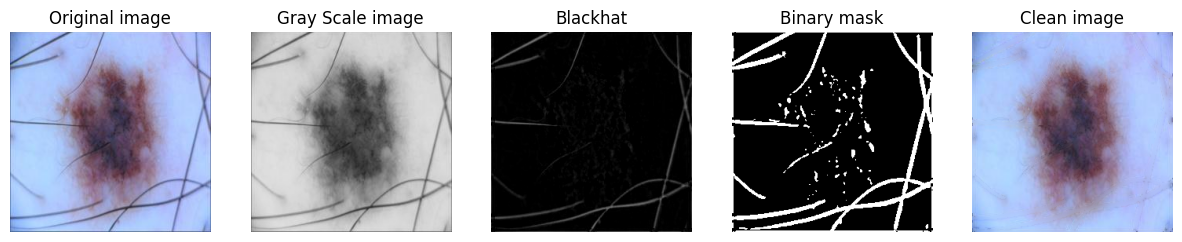

True

In [16]:
path = 'ISIC_0000042_resize.jpg'
image=cv2.imread(path,cv2.IMREAD_COLOR)

# DULL RAZOR (REMOVE HAIR)

# Gray scale
grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Black hat filter
kernel = cv2.getStructuringElement(1, (9, 9))
blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

# Gaussian filter
bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)

# Binary thresholding (MASK)
ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)

# Replace pixels of the mask
dst = cv2.inpaint(image, mask, 6, cv2.INPAINT_TELEA)

# Display images side by side using matplotlib
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

images = [image, grayScale, blackhat, mask, dst]
titles = ["Original image", "Gray Scale image", "Blackhat", "Binary mask", "Clean image"]

for i, ax in enumerate(axes):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.set_title(titles[i])
    ax.axis("off")

plt.show()
cv2.imwrite('ISIC_0000042_clean.jpg', dst)


### Segmentation

Une fois que nos images ont subies ces traitements nous pouvons procéder au détourage de celles-ci. Pour cela nous utilisons l'algorithme de segmentation Otsu. Pour cela nous récupérons l'histogramme de l'image puis nous utilisons la fonction treshold_otsu de scikit-image pour obtenir le seuil d'Otsu. Nous multiplions ensuite ce seuil par un facteur (ici 1.05 qui nous a semblé être le mieux compte tenu de nos essais) pour ajuster la binarisation. 

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_42328\908965500.py:77: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])


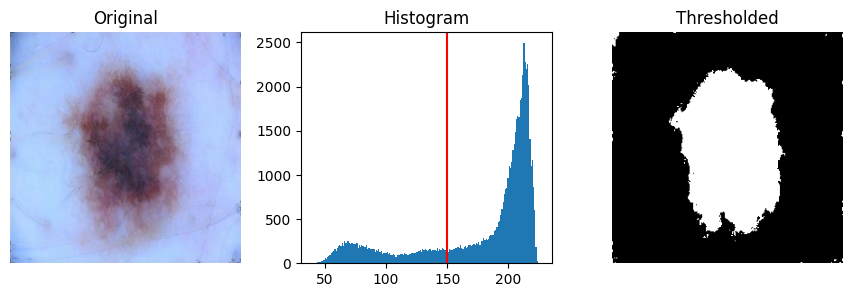

In [17]:
def histogram(im):
    
    nl,nc=im.shape
    
    hist=np.zeros(256)
    
    for i in range(nl):
        for j in range(nc):
            hist[im[i][j]]=hist[im[i][j]]+1
            
    for i in range(256):
        hist[i]=hist[i]/(nc*nl)
        
    return(hist)
    
    
def otsu_thresh(im):
    
    h=histogram(im)
    
    m=0
    for i in range(256):
        m=m+i*h[i]
    
    maxt=0
    maxk=0
    
    
    for t in range(256):
        w0=0
        w1=0
        m0=0
        m1=0
        for i in range(t):
            w0=w0+h[i]
            m0=m0+i*h[i]
        if w0 > 0:
            m0=m0/w0
        
        for i in range(t,256):
            w1=w1+h[i]
            m1=m1+i*h[i]
        if w1 > 0:   
            m1=m1/w1
        
        k=w0*w1*(m0-m1)*(m0-m1)    
        
        if k > maxk:
            maxk=k
            maxt=t
            
            
    thresh=maxt
        
    return(thresh)


image = skio.imread('ISIC_0000042_clean.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = threshold_otsu(image_gray)
thresh_multiplier = 1.05
binary = image_gray > thresh_multiplier * thresh

thresh=otsu_thresh(image_gray)
binary = image_gray > thresh_multiplier * thresh

inverted_image = np.invert(binary)

#Convert to uint8 and save the result
inverted_image_uint8 = (255 * inverted_image).astype(np.uint8)
cv2.imwrite('ISIC_0000042_seg.jpg', inverted_image_uint8)

fig, axes = plt.subplots(ncols=3, figsize=(11, 3))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

bins=np.max(image_gray)-np.min(image_gray)+1

ax[1].hist(image_gray.ravel(), bins=bins)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(inverted_image, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

### Indice de Dice

Pour comparer nos résultats avec ceux de la correction (détourage manuelle par un médecin par exemple), nous utilisons un indice de comparaison, l'indice de Dice. Plus le coefficient est proche de 1, plus les deux images se ressemblent.

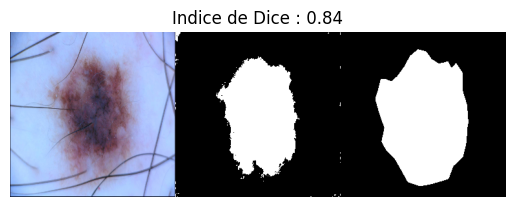

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger les deux images à comparer
image_base = cv2.imread('ISIC_0000042.jpg', cv2.IMREAD_COLOR)
base_resize = cv2.resize(image_base, (256, 256))  # Redimensionner pour avoir la même hauteur que les images binaires

image_prof = cv2.imread('ISIC_0000042_seg_correction.jpg', cv2.IMREAD_COLOR)
prof_resize = cv2.resize(image_prof, (256, 256))
image_etudiant = cv2.imread('ISIC_0000042_seg.jpg', cv2.IMREAD_COLOR)


# Convertir les images en binaire
_, image_prof_bin = cv2.threshold(prof_resize, 128, 255, cv2.THRESH_BINARY)
_, image_etudiant_bin = cv2.threshold(image_etudiant, 128, 255, cv2.THRESH_BINARY)

# Calculer l'indice de Sørensen-Dice
intersection = np.sum(np.logical_and(image_prof_bin, image_etudiant_bin))
union = np.sum(np.logical_or(image_prof_bin, image_etudiant_bin))
sorensen_dice = 2.0 * intersection / (intersection + union)

# Créer une image composée des trois images côte à côte
composite_image = np.concatenate((base_resize, image_etudiant_bin, image_prof_bin), axis=1)
cv2.imwrite('comparaison_image.jpg', composite_image)

# Afficher la valeur de l'indice de Dice sur l'image composite
plt.imshow(cv2.cvtColor(composite_image, cv2.COLOR_BGR2RGB))
plt.title(f"Indice de Dice : {sorensen_dice:.2f}")
plt.axis('off')
plt.show()


Pour cette image par exemple notre résultat est l'image du milieu et celle de la correction est celle de droite. L'indice de Dice est de 0.84 ce qui indique une ressemblance assez élevée. 

## Conclusion

Ce projet a réussi à mettre en œuvre la méthode demandée. Cependant, certaines images restent difficiles à traiter, notamment lorsqu'elles sont assez sombres car dans ces cas-là notre algorithme de suppression des bords noirs peut donner de faux résultats qui ne sont pas exploitables. Il y aurait donc des progès à faire pour assombrir ces zones et donc permettre une meilleure détection des contours.  